# Goals
- Determine the most valuable subscribers
- Understand subscriber segments
- What subscribers could be sold additional products/services
- Find the subscriber profile of those not continuing with the product
- Find out how to deepen subscriber engagement
- Identify any other opportunities that arise from analysis
## Questions
- Should we standardize purchase ammount, or recalculate based on the date data
- Due to some columns >50% null, should we do use some sampling techniques 
- Are the ids guaranteed to be unique 
## Contact Info
tonks@chapman.edu
flath@chapman.edu
jgonzalez@chapman.edu
tsirtsis@chapman.edu
dkeefe@chapman.edu


In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from scipy import stats
import datetime

C:\Users\jade5\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Subscriber Data

In [2]:
subscriber = pd.read_csv("data/subscriber.csv")
subscriber_full = pd.read_csv("data/subscriber_dummies.csv")
subscriber.head()

,ID,Language,Subscription Type,Subscription Event Type,Purchase Store,Purchase Amount,Currency,Subscription Start Date,Subscription Expiration,Demo User,...,Country,User Type,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
0,1,POR,Limited,INITIAL_PURCHASE,App,NaN,NaN,12/28/2018,6/28/2019,Yes,...,US/Canada,Consumer,App,Yes,Yes,63.0,7.0,0.0,6.0,0.0
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.0,USD,11/28/2019,2/28/2020,No,...,Other,Consumer,Web,No,Yes,4.0,3.0,0.0,1.0,0.0
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.0,USD,12/31/2018,12/31/2019,No,...,US/Canada,Consumer,Web,Yes,Yes,1.0,0.0,0.0,0.0,0.0
3,4,KOR,Limited,INITIAL_PURCHASE,App,NaN,NaN,11/7/2019,2/7/2020,Yes,...,US/Canada,Consumer,App,Yes,Yes,14.0,0.0,0.0,0.0,0.0
4,5,ENG,Limited,INITIAL_PURCHASE,App,NaN,NaN,8/13/2019,11/13/2019,No,...,US/Canada,Consumer,Web,Yes,Yes,80.0,5.0,1.0,5.0,1.0


In [3]:
subscriber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40102 entries, 0 to 40101
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       40102 non-null  int64  
 1   Language                 40102 non-null  object 
 2   Subscription Type        40102 non-null  object 
 3   Subscription Event Type  40102 non-null  object 
 4   Purchase Store           40102 non-null  object 
 5   Purchase Amount          26923 non-null  float64
 6   Currency                 26924 non-null  object 
 7   Subscription Start Date  40102 non-null  object 
 8   Subscription Expiration  40102 non-null  object 
 9   Demo User                40102 non-null  object 
 10  Free Trial User          40102 non-null  object 
 11  Free Trial Start Date    5833 non-null   object 
 12  Free Trial Expiration    5833 non-null   object 
 13  Auto Renew               40101 non-null  object 
 14  Country               

In [4]:
subscriber.describe()

,ID,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
count,40102.000000,2.692300e+04,28448.000000,28448.000000,28448.000000,28448.000000,28448.000000
mean,19980.310982,3.270582e+08,32.389307,8.233971,2.154246,3.892435,0.362943
std,11550.985627,1.681253e+10,58.436061,37.385582,29.366507,13.137642,1.132356
min,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9970.250000,0.000000e+00,4.000000,0.000000,0.000000,0.000000,0.000000
50%,19972.500000,3.881000e+01,10.000000,1.000000,0.000000,1.000000,0.000000
75%,29983.750000,1.523900e+02,33.000000,5.000000,0.000000,2.000000,0.000000
max,40000.000000,1.600000e+12,4370.000000,4365.000000,4348.000000,196.000000,44.000000


In [5]:
subscriber.isna().sum()

ID                             0
Language                       0
Subscription Type              0
Subscription Event Type        0
Purchase Store                 0
Purchase Amount            13179
Currency                   13178
Subscription Start Date        0
Subscription Expiration        0
Demo User                      0
Free Trial User                0
Free Trial Start Date      34269
Free Trial Expiration      34269
Auto Renew                     1
Country                        0
User Type                      0
Lead Platform                  0
Email Subscriber               0
Push Notifications             0
Send Count                 11654
Open Count                 11654
Click Count                11654
Unique Open Count          11654
Unique Click Count         11654
dtype: int64

> Thre currency column is not standardized and will greatly affect models if it is not set to one currency, we need to set all values in curency to USD. Currency exchange rates were taken from [here](https://www.x-rates.com/table/?from=USD&amount=1).

In [6]:
subscriber['Currency'].unique()

array([nan, 'USD', 'GBP', 'PLN', 'EUR', 'BRL', 'KRW', 'MXN', 'UAH', 'RUB',
       'CHF', 'CAD', 'CZK', 'RON', 'AUD', 'THB', 'JPY', 'INR', 'COP',
       'BGN', 'ZAR', 'HUF', 'SAR', 'TRY', 'SGD', 'VND', 'RSD', 'ILS',
       'SEK', 'PHP', 'NOK', 'EGP', 'QAR', 'IDR', 'PEN', 'AED', 'LBP',
       'KZT', 'GHS', 'HKD', 'CLP', 'CRC', 'NZD', 'DKK', 'MYR'],
      dtype=object)

In [7]:
usd_convert = {'USD' : 1,
               'GBP' : 1.39,
               'PLN' : 0.26,
               'EUR' : 1.21,
               'BRL' : 0.18,
               'KRW' : 0.0009,
               'MXN' : 0.5,
               'UAH' : 0.36,
               'RUB' : 0.13,
               'CHF' : 1.09,
               'CAD' : 0.81,
               'CZK' : 0.47,
               'RON' : 0.25,
               'AUD' : 0.78,
               'THB' : 0.32,
               'JPY' : 0.0092,
               'INR' : 0.013,
               'COP' : 0.00028,
               'BGN' : 0.62,
               'ZAR' : 0.7,
               'HUF' : 0.0033,
               'SAR' : 0.27,
               'TRY' : 0.12,
               'SGD' : 0.75,
               'VND' : 0.000043,
               'RSD' : 0.01,
               'ILS' : 0.31,
               'SEK' : 0.12,
               'PHP' : 0.021,
               'NOK' : 0.12,
               'EGP' : 0.064,
               'QAR' : 0.27,
               'IDR' : 0.000069,
               'PEN' : 0.26,
               'AED' : 0.27,
               'LBP' : 0.00066,
               'KZT' : 0.0023,
               'GHS' : 0.17,
               'HKD' : 0.13,
               'CLP' : 0.0014,
               'CRC' : 0.0016,
               'NZD' : 0.072,
               'DKK' : 0.16,
               'MYR' : 0.24}

In [8]:
for index in subscriber.index:
    if subscriber.at[index, 'Currency'] is np.nan:
        continue
    elif subscriber.at[index, 'Currency'] != 'USD':
        current_val = subscriber.at[index, 'Purchase Amount']
        new_val = current_val * usd_convert[subscriber.at[index, 'Currency']]
        subscriber.at[index, 'Purchase Amount'] = new_val
        subscriber.at[index, 'Currency'] = 'USD'
    else:
        continue
        
subscriber['Purchase Amount'] = subscriber['Purchase Amount'].apply(lambda x: round(x, 2))
#subscriber.to_csv("data/subscriber_clean.csv")
subscriber.head(20)

for index in subscriber_full.index:
    if subscriber_full.at[index, 'Currency'] is np.nan:
        continue
    elif subscriber_full.at[index, 'Currency'] != 'USD':
        current_val = subscriber_full.at[index, 'Purchase Amount']
        new_val = current_val * usd_convert[subscriber_full.at[index, 'Currency']]
        subscriber_full.at[index, 'Purchase Amount'] = new_val
        subscriber_full.at[index, 'Currency'] = 'USD'
    else:
        continue
        
subscriber_full['Purchase Amount'] = subscriber_full['Purchase Amount'].apply(lambda x: round(x, 2))
subscriber_full.head()

,ID,Language,Subscription Type,Subscription Event Type,Purchase Store,Purchase Amount,Currency,Subscription Start Date,Subscription Expiration,Demo User,...,IND,PAS,SubType,Demo User.1,Free Trial User.1,US/Canada,Other,Europe,EmailSub,PushNotifications
0,1,POR,Limited,INITIAL_PURCHASE,App,NaN,NaN,12/28/2018,6/28/2019,Yes,...,0,0,1,1,0,1,0,0,1,1
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.0,USD,11/28/2019,2/28/2020,No,...,0,0,1,0,0,0,1,0,0,1
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.0,USD,12/31/2018,12/31/2019,No,...,0,0,1,0,0,1,0,0,1,1
3,4,KOR,Limited,INITIAL_PURCHASE,App,NaN,NaN,11/7/2019,2/7/2020,Yes,...,0,0,1,1,0,1,0,0,1,1
4,5,ENG,Limited,INITIAL_PURCHASE,App,NaN,NaN,8/13/2019,11/13/2019,No,...,0,0,1,0,0,1,0,0,1,1


>Purchase amount and currency is standardized to USD, now to take care of outliers

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 13179 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


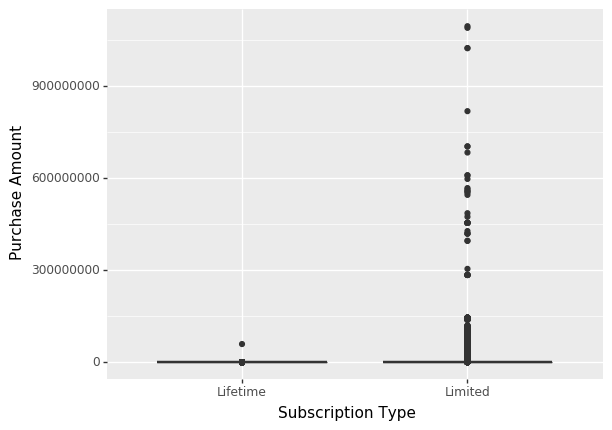

<ggplot: (-9223371850734452436)>

In [9]:
ggplot(subscriber) + geom_boxplot(aes(x = 'Subscription Type' , y = 'Purchase Amount'))

> Very unrealistic purchase amounts appear for mostly Limited subscriptions, dropping those with a purchase amount of above 300 as the max purchase price of a Rosetta Stone service is 299

In [10]:
subscriber.drop(subscriber.loc[subscriber['Purchase Amount'] > 300].index, inplace=True)
subscriber_full.drop(subscriber_full.loc[subscriber_full['Purchase Amount'] > 300].index, inplace=True)
subscriber.describe()

,ID,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
count,38438.000000,25259.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000
mean,20176.260393,69.698572,33.213973,8.439334,2.197511,4.000913,0.369580
std,11551.334791,75.436699,59.239086,37.989768,29.905087,13.327759,1.142726
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10203.250000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,20261.500000,36.940000,10.000000,1.000000,0.000000,1.000000,0.000000
75%,30209.750000,119.000000,35.000000,6.000000,0.000000,2.000000,0.000000
max,40000.000000,299.000000,4370.000000,4365.000000,4348.000000,196.000000,44.000000


In [11]:
subscriber.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38438 entries, 0 to 40101
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       38438 non-null  int64  
 1   Language                 38438 non-null  object 
 2   Subscription Type        38438 non-null  object 
 3   Subscription Event Type  38438 non-null  object 
 4   Purchase Store           38438 non-null  object 
 5   Purchase Amount          25259 non-null  float64
 6   Currency                 25260 non-null  object 
 7   Subscription Start Date  38438 non-null  object 
 8   Subscription Expiration  38438 non-null  object 
 9   Demo User                38438 non-null  object 
 10  Free Trial User          38438 non-null  object 
 11  Free Trial Start Date    5378 non-null   object 
 12  Free Trial Expiration    5378 non-null   object 
 13  Auto Renew               38437 non-null  object 
 14  Country               

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 13179 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


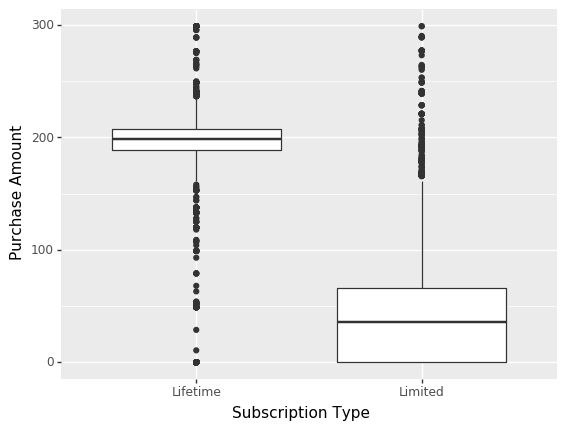

<ggplot: (-9223371850733646476)>

In [12]:
ggplot(subscriber) + geom_boxplot(aes(x = 'Subscription Type' , y = 'Purchase Amount'))

> The distribution is looking much better, still unsure why some purchase amounts are so high given that the most expensive Consumer product on Rosetta Stone is 299

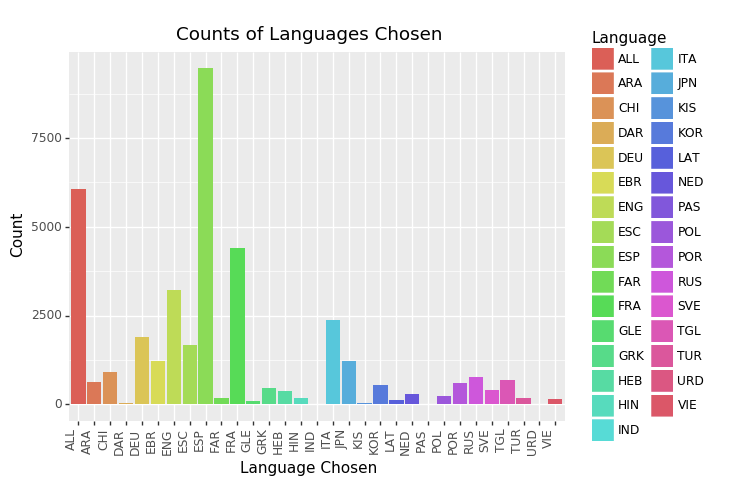

<ggplot: (-9223371850733646380)>

In [13]:
# Comparison of language chosen
ggplot(subscriber, aes(x = 'Language', fill = 'Language')) +  geom_bar() + ylab('Count') + xlab('Language Chosen') +  ggtitle('Counts of Languages Chosen') + theme(axis_text_x=element_text(rotation=90, hjust=1))

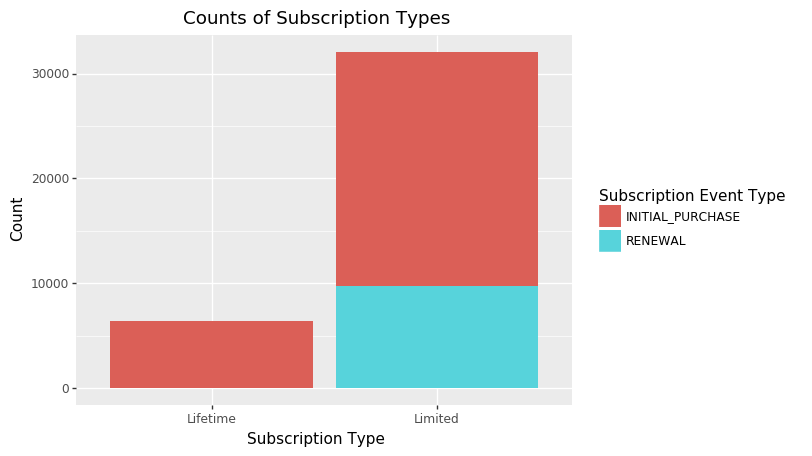

<ggplot: (-9223371850733595684)>

In [14]:
# Type of subscriptions
ggplot(subscriber, aes(x = 'Subscription Type', fill = 'Subscription Event Type')) + geom_bar() + ylab('Count') + xlab('Subscription Type') + ggtitle('Counts of Subscription Types')

> There are very few lifetime subscription purchase compared to limited subscriptions, additionally many subscribers do not renew their subscription (high churn)

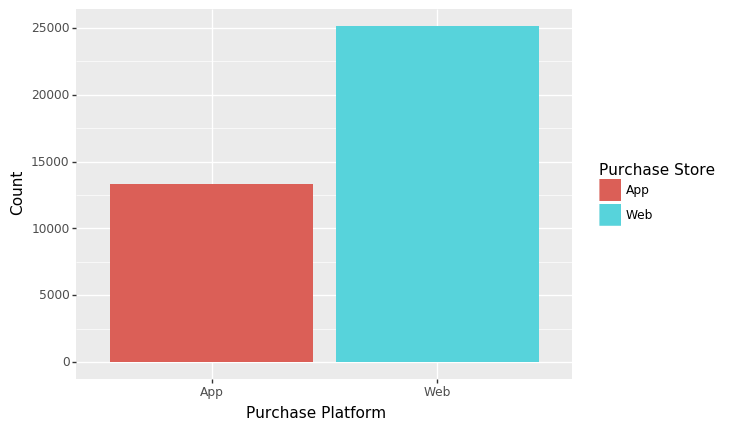

<ggplot: (-9223371850733624548)>

In [15]:
# Purchase platform
ggplot(subscriber, aes(x = 'Purchase Store', fill = 'Purchase Store')) + geom_bar() + ylab('Count') + xlab('Purchase Platform')

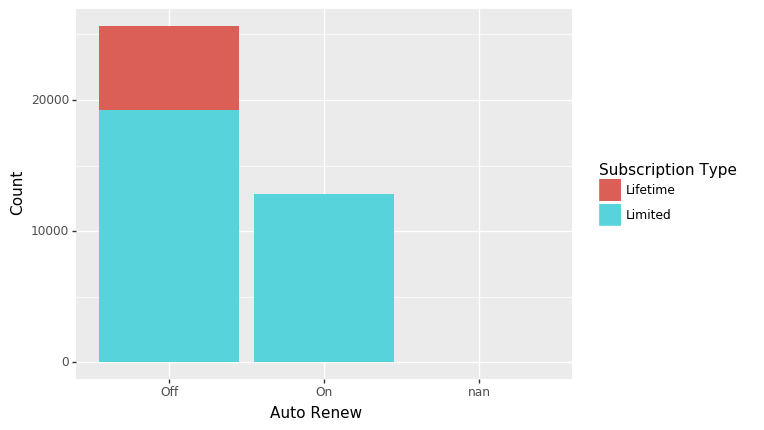

<ggplot: (-9223371850733791648)>

In [16]:
# Auto Renew
# Type of subscriptions
ggplot(subscriber, aes(x = 'Auto Renew', fill = 'Subscription Type')) + geom_bar() + ylab('Count') + xlab('Auto Renew')

> Lifetime subscriptions will not have auto renew on, but more subscribers with a limited subscripsion turn auto renew off

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 26'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


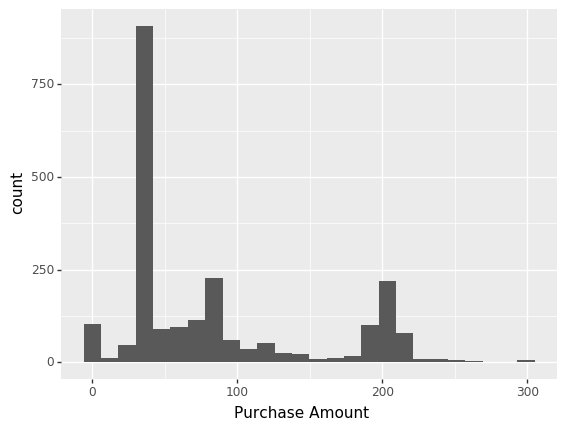

<ggplot: (-9223371850733687128)>

In [17]:
purchase_amount = subscriber
purchase_amount.dropna(inplace = True)
ggplot(purchase_amount, aes(x = 'Purchase Amount')) + geom_histogram()

### App Activity

In [18]:
app_act = pd.read_csv("data/appactivity.csv")
app_act.head()

,ID,App Session Platform,App Activity Type,App Session Date
0,1,ios,App Launch,3/20/2019
1,2,android,App Launch,12/3/2019
2,3,ios,App Launch,5/2/2019
3,4,ios,App Launch,2/6/2020
4,5,ios,Start,9/14/2019


In [19]:
app_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809478 entries, 0 to 809477
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   ID                    809478 non-null  int64 
 1   App Session Platform  765300 non-null  object
 2   App Activity Type     795058 non-null  object
 3   App Session Date      795058 non-null  object
dtypes: int64(1), object(3)
memory usage: 24.7+ MB


In [20]:
app_act.isna().sum()

ID                          0
App Session Platform    44178
App Activity Type       14420
App Session Date        14420
dtype: int64

> Null values make up less than 1% of the data so it would be best to just drop these

In [21]:
app_act.dropna(inplace = True)
app_act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 765300 entries, 0 to 809477
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   ID                    765300 non-null  int64 
 1   App Session Platform  765300 non-null  object
 2   App Activity Type     765300 non-null  object
 3   App Session Date      765300 non-null  object
dtypes: int64(1), object(3)
memory usage: 29.2+ MB


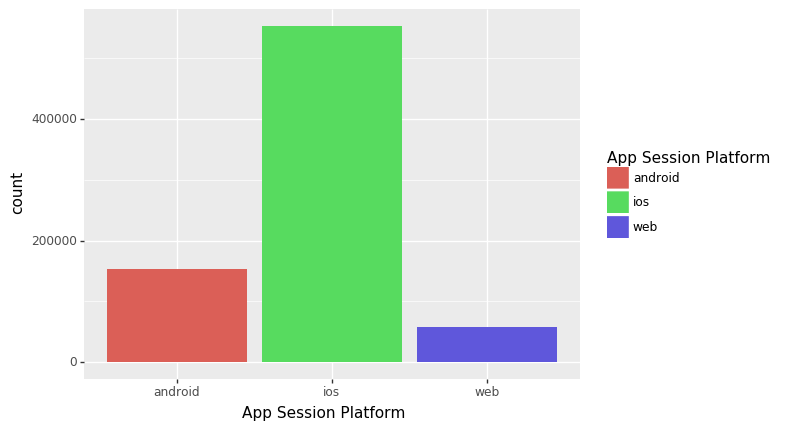

<ggplot: (-9223371850733481820)>

In [22]:
ggplot(app_act, aes(x = 'App Session Platform', fill = 'App Session Platform')) + geom_bar()

> A majority of subscribers are present on Apple platforms

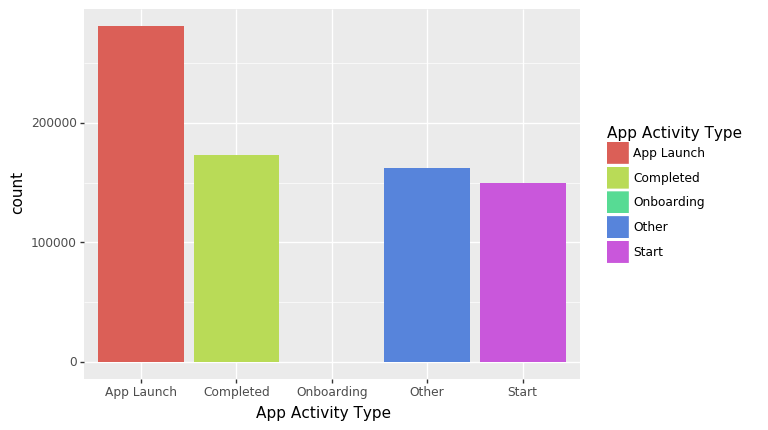

<ggplot: (-9223371850733061380)>

In [23]:
ggplot(app_act, aes(x = 'App Activity Type', fill = 'App Activity Type')) + geom_bar()

### Subscriber Segments
> [source](https://inseaddataanalytics.github.io/INSEADAnalytics/CourseSessions/Sessions45/ClusterAnalysisReading.html)

In [24]:
subscriber.head()

,ID,Language,Subscription Type,Subscription Event Type,Purchase Store,Purchase Amount,Currency,Subscription Start Date,Subscription Expiration,Demo User,...,Country,User Type,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
8,9,DEU,Limited,INITIAL_PURCHASE,Web,43.16,USD,3/3/2020,6/8/2020,No,...,Europe,Consumer,Web,No,Yes,52.0,11.0,0.0,5.0,0.0
11,12,ESP,Limited,INITIAL_PURCHASE,Web,35.97,USD,10/17/2019,1/21/2020,No,...,US/Canada,Consumer,Web,Yes,Yes,94.0,0.0,0.0,0.0,0.0
16,17,ALL,Lifetime,INITIAL_PURCHASE,Web,199.00,USD,3/25/2020,1/1/2099,No,...,US/Canada,Consumer,Web,Yes,Yes,8.0,6.0,3.0,2.0,1.0
41,42,ESP,Limited,INITIAL_PURCHASE,Web,38.89,USD,1/27/2020,4/30/2020,No,...,US/Canada,Consumer,Web,Yes,Yes,19.0,11.0,4.0,7.0,2.0
42,43,RUS,Limited,INITIAL_PURCHASE,Web,39.00,USD,8/22/2019,11/25/2019,No,...,Europe,Consumer,Web,No,Yes,79.0,56.0,1.0,38.0,1.0


In [25]:
subscriber[["Subscription Start Date", "Subscription Expiration"]] = subscriber[["Subscription Start Date", "Subscription Expiration"]].apply(pd.to_datetime)

subscriber["InvoiceDate"] = subscriber["Subscription Start Date"].dt.date
recent_date = max(subscriber.InvoiceDate) + datetime.timedelta(days = 1)
customers = subscriber.groupby(['ID']).agg({
    'InvoiceDate' : lambda x: (recent_date - x.max()).days,
    'Subscription Event Type' : 'count',
    'Purchase Amount' : 'sum'})
customers.rename(columns = {'InvoiceDate' : 'Recency',
                            'Subscription Event Type' : 'Frequency',
                            'Purchase Amount' : 'Monetary Value'}, inplace = True)

In [26]:
customers.head()

,Recency,Frequency,Monetary Value
ID,,,
9,29,1,43.16
12,167,1,35.97
17,7,1,199.00
42,65,1,38.89
43,223,1,39.00


In [27]:
customers_fixed = pd.DataFrame()
customers_fixed["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fixed["Frequency"] = pd.Series(np.log(customers['Frequency'])).values
customers_fixed["MonetaryValue"] = pd.Series(np.cbrt(customers['Monetary Value'])).values

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 14'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


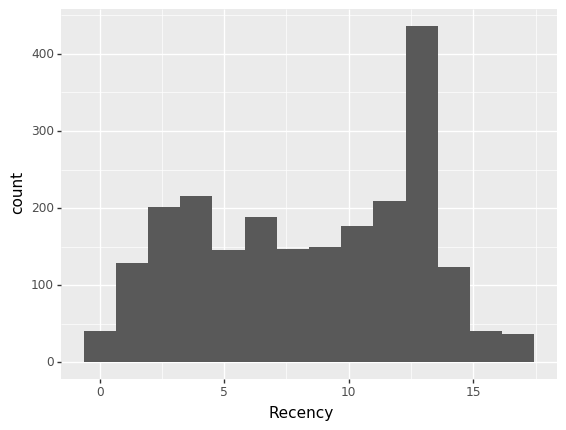

<ggplot: (-9223371850733409772)>

In [28]:
ggplot(customers_fixed, aes(x = 'Recency')) + geom_histogram()

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 48'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


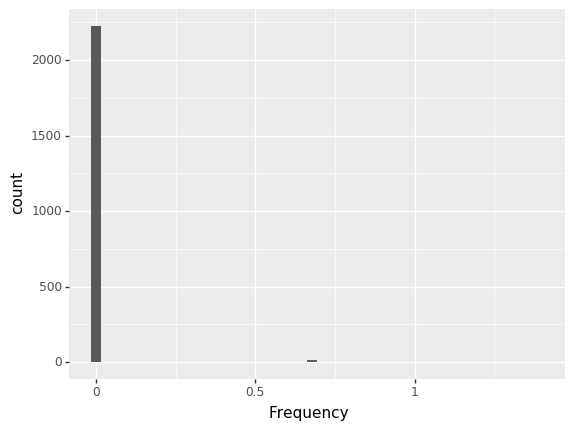

<ggplot: (-9223371850733417568)>

In [29]:
ggplot(customers_fixed, aes(x = 'Frequency')) + geom_histogram()

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 31'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


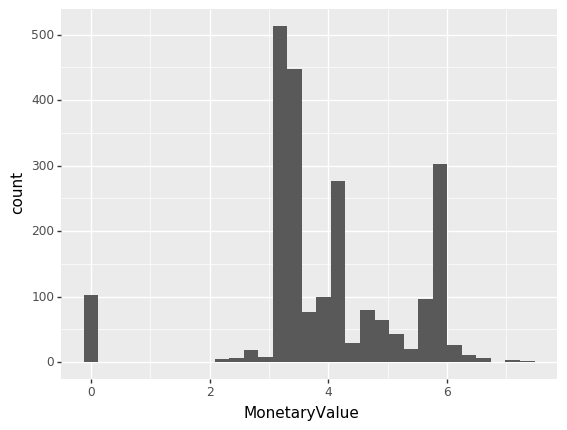

<ggplot: (-9223371850733371248)>

In [30]:
ggplot(customers_fixed, aes(x = 'MonetaryValue')) + geom_histogram()

In [31]:
scaler = StandardScaler()

scaler.fit(customers_fixed)
customers_norm = scaler.transform(customers_fixed)
print(customers_norm.mean(axis = 0).round(2))

[0. 0. 0.]


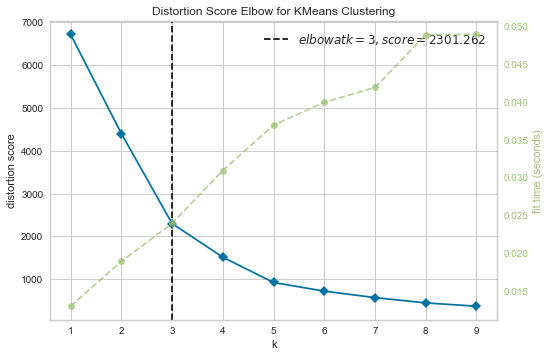

In [32]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,10))
visualizer.fit(customers_norm)
visualizer.show()

In [33]:
kmm = KMeans(n_clusters = 3, random_state = 410)
kmm.fit(customers_norm)
kmm.labels_.shape

(2239,)

In [34]:
customers["Cluster"] = kmm.labels_
customers.groupby('Cluster').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary Value' : ['mean', 'count']}).round(2)

Recency Frequency Monetary Value      
           mean      mean           mean count
Cluster                                       
0         20.41      1.00         131.10   908
1        207.26      1.00          49.48  1317
2         46.00      2.14         221.05    14

In [35]:
subscribers_norm = pd.DataFrame(customers_norm, columns = ['Recency', 'Frequency', 'Monetary Value'])
subscribers_norm['ID'] = customers.index
subscribers_norm['Cluster'] = kmm.labels_

subscribers_melt = pd.melt(subscribers_norm.reset_index(),
                          id_vars = ['ID', 'Cluster'],
                          value_vars = ['Recency', 'Frequency', 'Monetary Value'],
                          var_name = 'Attribute',
                          value_name = 'Value')
subscribers_melt.head()

,ID,Cluster,Attribute,Value
0,9,0,Recency,-0.662250
1,12,1,Recency,0.614656
2,17,0,Recency,-1.332775
3,42,1,Recency,-0.148500
4,43,1,Recency,0.890654


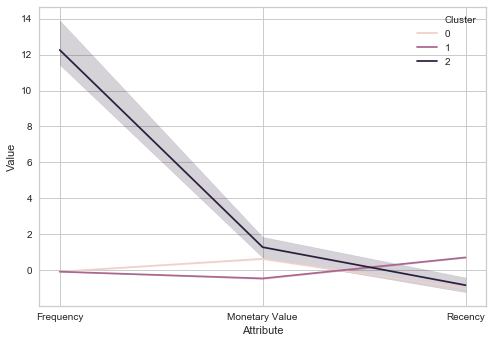

In [36]:
sb.lineplot('Attribute', 'Value', hue = 'Cluster', data = subscribers_melt)

### What type of subscribers are present?
> From the above snakeplot we see three differing representations of subscribers found in the dataset.  
- **Cluster 0** is infrequent, of moderate value, and purchases recently, this could indicate a new customer or a lifetime customer due to having a one time purchase.
- **Cluster 1** is also infrequent, of the least value, and purchases products less recent, this most likely indicates subscribers who do not continue to use Rosetta Stone (churned customers)
- **Cluster 2** is very frequent, of the most value, and purchases recently, this is likely a loyal and/or lifetime subscription user.

In [37]:
subscribers_clust = subscribers_melt.drop(['Attribute', 'Value'], axis=1)
subscribers_clust

,ID,Cluster
0,9,0
1,12,1
2,17,0
3,42,1
4,43,1
...,...,...
6712,39429,0
6713,39471,1
6714,39564,1
6715,39743,1


In [38]:
subscriber = subscriber.merge(subscribers_clust, how = 'left', on = 'ID')
subscriber.drop_duplicates(inplace = True)
subscriber.head()

,ID,Language,Subscription Type,Subscription Event Type,Purchase Store,Purchase Amount,Currency,Subscription Start Date,Subscription Expiration,Demo User,...,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count,InvoiceDate,Cluster
0,9,DEU,Limited,INITIAL_PURCHASE,Web,43.16,USD,2020-03-03,2020-06-08,No,...,Web,No,Yes,52.0,11.0,0.0,5.0,0.0,2020-03-03,0
3,12,ESP,Limited,INITIAL_PURCHASE,Web,35.97,USD,2019-10-17,2020-01-21,No,...,Web,Yes,Yes,94.0,0.0,0.0,0.0,0.0,2019-10-17,1
6,17,ALL,Lifetime,INITIAL_PURCHASE,Web,199.00,USD,2020-03-25,2099-01-01,No,...,Web,Yes,Yes,8.0,6.0,3.0,2.0,1.0,2020-03-25,0
9,42,ESP,Limited,INITIAL_PURCHASE,Web,38.89,USD,2020-01-27,2020-04-30,No,...,Web,Yes,Yes,19.0,11.0,4.0,7.0,2.0,2020-01-27,1
12,43,RUS,Limited,INITIAL_PURCHASE,Web,39.00,USD,2019-08-22,2019-11-25,No,...,Web,No,Yes,79.0,56.0,1.0,38.0,1.0,2019-08-22,1


In [39]:
subscriber['Cluster'] = subscriber['Cluster'].astype('category')

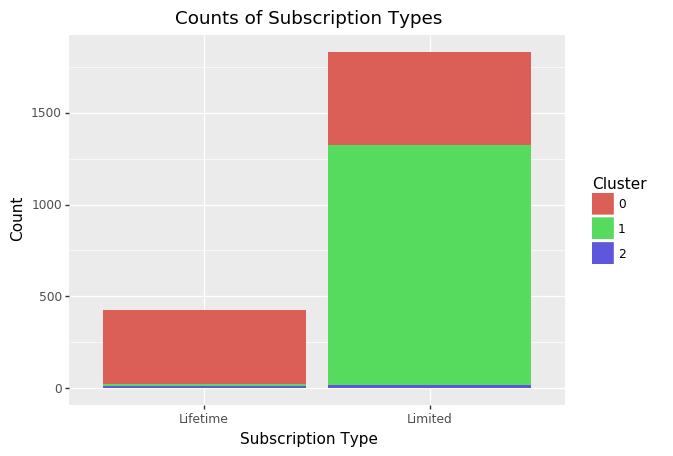

<ggplot: (-9223371850732292220)>

In [40]:
# Type of subscriptions
ggplot(subscriber, aes(x = 'Subscription Type', fill = 'Cluster')) + geom_bar() + ylab('Count') + xlab('Subscription Type') + ggtitle('Counts of Subscription Types')

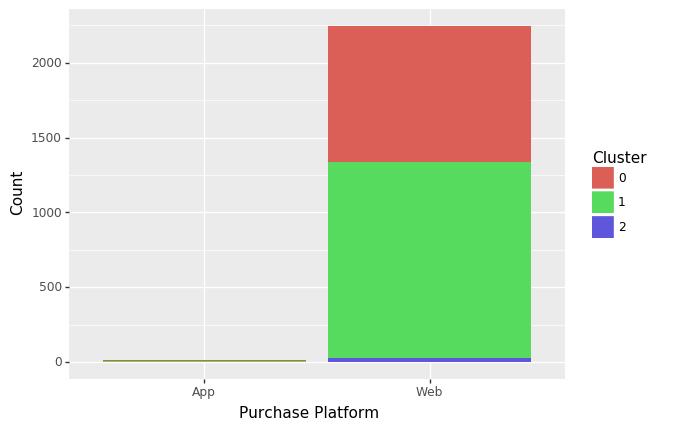

<ggplot: (-9223371850732287120)>

In [41]:
ggplot(subscriber, aes(x = 'Purchase Store', fill = 'Cluster')) + geom_bar() + ylab('Count') + xlab('Purchase Platform')

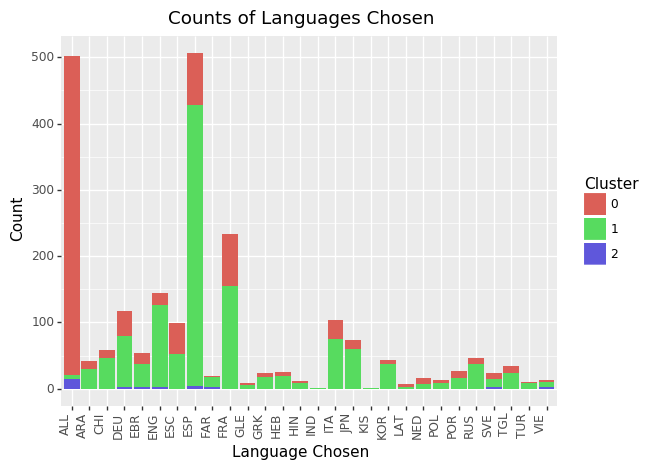

<ggplot: (-9223371850732299444)>

In [42]:
# Comparison of language chosen
ggplot(subscriber, aes(x = 'Language', fill = 'Cluster')) +  geom_bar() + ylab('Count') + xlab('Language Chosen') +  ggtitle('Counts of Languages Chosen') + theme(axis_text_x=element_text(rotation=90, hjust=1))

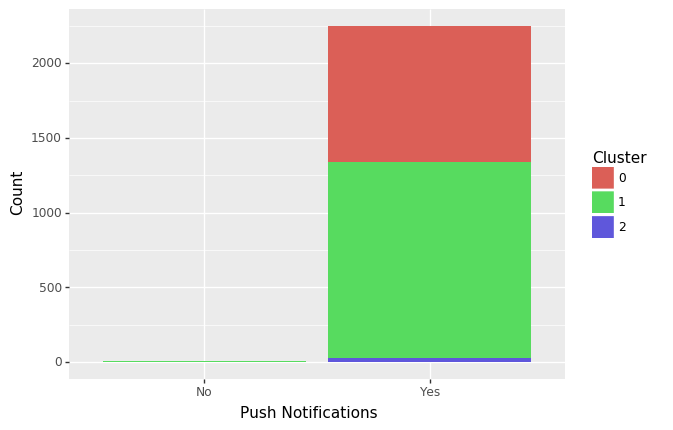

<ggplot: (-9223371850732336488)>

In [43]:
ggplot(subscriber, aes(x = 'Push Notifications', fill = 'Cluster')) + geom_bar() + ylab('Count') + xlab('Push Notifications')

In [44]:
subscriber_c0 = subscriber[subscriber.Cluster == 0]
subscriber_c1 = subscriber[subscriber.Cluster == 1]
subscriber_c2 = subscriber[subscriber.Cluster == 2]

In [45]:
subscriber_c0.describe()

,ID,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.00000
mean,13547.241189,131.103601,36.607930,18.607930,8.894273,5.829295,1.11674
std,8357.671673,74.295747,62.763697,47.340546,36.288806,13.806209,1.87528
min,9.000000,19.990000,1.000000,0.000000,0.000000,0.000000,0.00000
25%,6760.000000,44.600000,6.000000,1.000000,0.000000,1.000000,0.00000
50%,13319.000000,140.685000,11.000000,6.000000,1.000000,2.000000,1.00000
75%,19305.000000,199.000000,33.000000,17.000000,6.000000,5.000000,2.00000
max,39429.000000,299.000000,618.000000,615.000000,615.000000,141.000000,29.00000


In [46]:
subscriber_c1.describe()

,ID,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
count,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000
mean,13424.695520,49.480046,44.930904,14.025816,6.378132,4.945330,0.517084
std,9331.608988,30.942440,131.182513,123.283155,120.703157,14.488966,1.472356
min,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5672.000000,35.970000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,11942.000000,39.000000,16.000000,2.000000,0.000000,1.000000,0.000000
75%,19765.000000,65.940000,58.000000,9.000000,1.000000,3.000000,1.000000
max,39953.000000,239.520000,4370.000000,4365.000000,4348.000000,192.000000,30.000000


In [47]:
subscriber_c2.describe()

,ID,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,6507.933333,103.158667,28.000000,12.533333,6.800000,4.066667,1.266667
std,6746.837026,71.741585,46.462443,15.544671,9.136513,6.648481,1.680175
min,1775.000000,18.920000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2332.000000,35.970000,1.250000,1.000000,0.000000,1.000000,0.000000
50%,4921.000000,101.060000,7.000000,5.000000,1.000000,2.000000,1.000000
75%,6167.500000,189.000000,27.750000,25.750000,14.250000,2.750000,1.750000
max,29296.000000,199.000000,145.000000,40.000000,27.000000,25.000000,5.000000


In [48]:
# Exports
# Subscriber cleaned with clusters
subscriber.to_csv('data/subscribers_cluters.csv')

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 11042 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


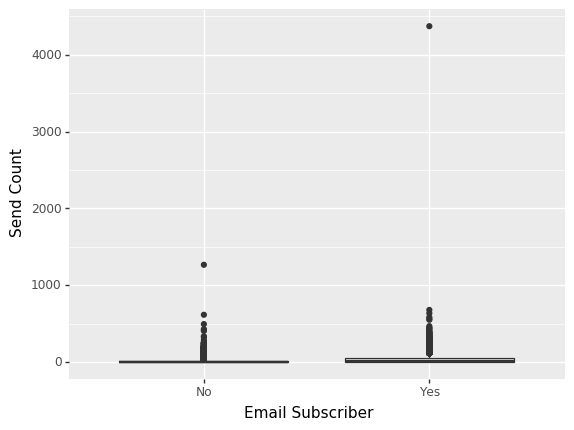

<ggplot: (-9223371850733598824)>

In [49]:
ggplot(subscriber_full, aes(x = 'Email Subscriber', y = 'Send Count')) + geom_boxplot()

In [50]:
subscriber_full.drop(subscriber_full.loc[subscriber_full['Send Count'] > 1000].index, inplace=True)

In [51]:
subscriber_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38436 entries, 0 to 40101
Data columns (total 64 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       38436 non-null  int64  
 1   Language                 38436 non-null  object 
 2   Subscription Type        38436 non-null  object 
 3   Subscription Event Type  38436 non-null  object 
 4   Purchase Store           38436 non-null  object 
 5   Purchase Amount          25257 non-null  float64
 6   Currency                 25258 non-null  object 
 7   Subscription Start Date  38436 non-null  object 
 8   Subscription Expiration  38436 non-null  object 
 9   Demo User                38436 non-null  object 
 10  Free Trial User          38436 non-null  object 
 11  Free Trial Start Date    5377 non-null   object 
 12  Free Trial Expiration    5377 non-null   object 
 13  Auto Renew               38435 non-null  object 
 14  Country               

In [52]:
sub_clean = subscriber_full.drop(columns=['Subscription Type','POR.1','Subscription Event Type','Purchase Store','Currency','Subscription Start Date','Subscription Expiration','Demo User','Free Trial User','Free Trial Start Date','Free Trial Expiration','Auto Renew','Country','User Type','Lead Platform','Email Subscriber','Push Notifications','Language','ID'
])
sub_clean.isna().sum()
sub_clean[["Purchase Amount"]] = sub_clean[["Purchase Amount"]].fillna(sub_clean[["Purchase Amount"]].mean())
sub_clean[["Send Count"]] = sub_clean[["Send Count"]].fillna(sub_clean[["Send Count"]].mean())
sub_clean[["Open Count"]] = sub_clean[["Open Count"]].fillna(sub_clean[["Open Count"]].mean())
sub_clean[["Click Count"]] = sub_clean[["Click Count"]].fillna(sub_clean[["Click Count"]].mean())
sub_clean[["Unique Open Count"]] = sub_clean[["Unique Open Count"]].fillna(sub_clean[["Unique Open Count"]].mean())
sub_clean[["Unique Click Count"]] = sub_clean[["Unique Click Count"]].fillna(sub_clean[["Unique Click Count"]].mean())


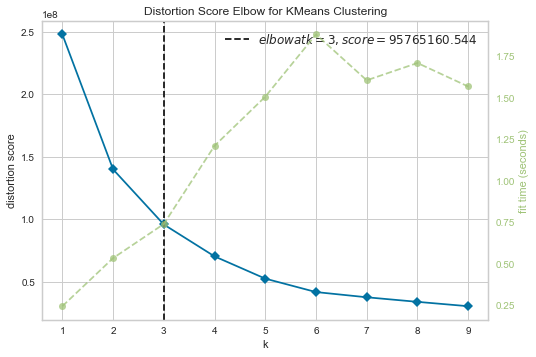

In [53]:
Km_gen = KMeans()
visualizer = KElbowVisualizer(km, k=(1,10))
visualizer.fit(sub_clean)
visualizer.show()

In [54]:
km = KMeans(n_clusters=3)
label = km.fit_predict(sub_clean)
filt_label0=sub_clean[label==0]
filt_label1=sub_clean[label==1]
filt_label2=sub_clean[label==2]

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text xticklabel objects>)

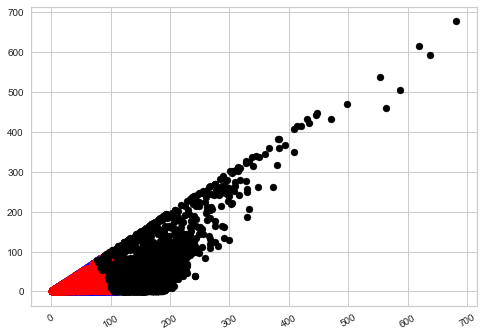

In [55]:
plt.scatter(filt_label0['Send Count'],filt_label0['Open Count'],color = 'blue')
plt.scatter(filt_label1['Send Count'],filt_label1['Open Count'],color = 'red')
plt.scatter(filt_label2['Send Count'],filt_label2['Open Count'],color = 'black')
plt.xticks(rotation=30)

In [56]:
filt_label0.describe()

,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count,POR,EBR,ESP,KOR,...,IND,PAS,SubType,Demo User.1,Free Trial User.1,US/Canada,Other,Europe,EmailSub,PushNotifications
count,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,...,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000,30092.000000
mean,46.932415,22.850355,5.046707,1.233932,2.321012,0.250510,0.017646,0.037086,0.275887,0.015419,...,0.000598,0.000066,0.950086,0.362256,0.148079,0.482454,0.381065,0.136481,0.456035,0.684069
std,30.227738,18.602494,6.663838,3.151310,3.052528,0.452832,0.131663,0.188976,0.446968,0.123216,...,0.024451,0.008152,0.217770,0.480660,0.355184,0.499700,0.485657,0.343305,0.498072,0.464893
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.870000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.692980,24.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,69.692980,33.010586,8.236731,1.997445,3.999124,0.369168,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,117.050000,117.000000,83.000000,81.000000,55.000000,9.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
filt_label1.describe()

,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count,POR,EBR,ESP,KOR,...,IND,PAS,SubType,Demo User.1,Free Trial User.1,US/Canada,Other,Europe,EmailSub,PushNotifications
count,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000,...,5824.0,5824.0,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000,5824.000000
mean,186.339102,25.904533,7.198571,2.305857,3.207833,0.565251,0.005323,0.010646,0.081387,0.005151,...,0.0,0.0,0.261161,0.173935,0.092891,0.418441,0.518201,0.063359,0.401614,0.509272
std,35.266520,37.094548,12.059532,6.308027,5.935052,1.243583,0.072769,0.102636,0.273453,0.071592,...,0.0,0.0,0.439305,0.379087,0.290305,0.493346,0.499712,0.243628,0.490267,0.499957
min,116.890000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,179.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,199.000000,8.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,202.230000,33.010586,8.236731,1.997445,3.999124,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,299.000000,182.000000,116.000000,107.000000,94.000000,44.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
filt_label2.describe()

,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count,POR,EBR,ESP,KOR,...,IND,PAS,SubType,Demo User.1,Free Trial User.1,US/Canada,Other,Europe,EmailSub,PushNotifications
count,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,...,2520.000000,2520.0,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000
mean,71.900873,170.759524,48.728968,10.401984,25.866667,1.332937,0.016270,0.013889,0.271429,0.015873,...,0.000397,0.0,0.765476,0.401587,0.150794,0.893254,0.052778,0.053968,0.890873,0.991270
std,74.894021,49.452831,70.455631,37.794685,34.999355,2.638589,0.126537,0.117053,0.444785,0.125009,...,0.019920,0.0,0.423785,0.490317,0.357919,0.308851,0.223634,0.226000,0.311860,0.093045
min,0.000000,78.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,142.000000,5.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,69.692980,168.000000,22.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,95.880000,190.250000,63.000000,5.000000,32.000000,2.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,268.920000,681.000000,678.000000,615.000000,196.000000,36.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split


y = sub_clean["Purchase Amount"]
x = sub_clean.drop(columns = ['Purchase Amount'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

<Figure size 138240x77760 with 0 Axes>

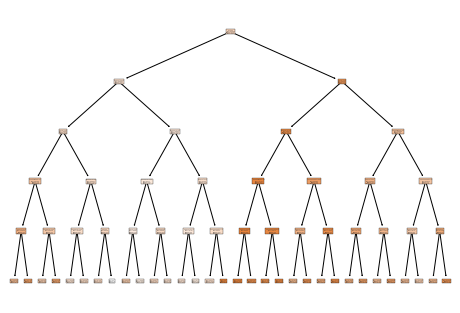

In [60]:
regressor = RandomForestRegressor(random_state=0,max_depth = 5)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
plt.figure(figsize=(1920,1080))
plt.figure()
out = tree.plot_tree(regressor.estimators_[0],
               feature_names = x.columns,
               filled = True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)

In [62]:
from sklearn.tree import export_graphviz

export_graphviz(regressor.estimators_[0], out_file = 'tree.dot', feature_names = x.columns, rounded = True, precision = 1,filled = True)